# Import

In [2]:
import numpy as np
import json
from scipy.sparse import load_npz,save_npz,diags,csr_matrix
import scipy.sparse as sp
import pandas as pd
import os
import requests
from io import BytesIO
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from pypdf import PdfReader, PdfWriter
from tempfile import NamedTemporaryFile
import networkx as nx
import pickle
import gseapy as gp
import mygene
from IPython.display import display, HTML
import re
from collections import deque
import math
from itertools import combinations
from collections import Counter
from gseapy.parser import read_gmt
import random
import igraph as ig

# Initialization

In [28]:
# LIST_OF_DISEASES = ["BIPOLAR","SCHIZOPHRENIA","LEUKEMIA","NONE"]
LIST_OF_DISEASES = ["BIPOLAR", "NONE"]
LIST_OF_DISEASES_CLEAN = [x for x in LIST_OF_DISEASES if x != "NONE"]
SIZE_CAP = 30 # community size cap

In [23]:
def jaccard(a, b):
    a, b = set(a), set(b)
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union else 0.0

In [24]:
disease_to_df = {}
for disease in LIST_OF_DISEASES:
   disease_to_df[disease] = pd.read_csv(f"../output/{disease}/important_terms_{disease}.csv")

In [25]:
def load_info(disease):
    DISEASE_FOLDER = f"../output/{disease}/"
    RESULT_FOLDER = DISEASE_FOLDER + "leiden_results/"
    DGIDB_DIRECTORY = f"../../Gen_Hypergraph/output/DGIDB_{disease}/"
    RESULT_COMMUNITIES = "result_communities"
    RESULT_GRAPH = "result_graph"

    with open(DISEASE_FOLDER + "gene_to_index_distinct.json", "r") as file:
        gene_to_index_distinct = json.load(file)
    with open(DGIDB_DIRECTORY + f"gene_to_index.json", "r") as file:
        DGIDB_gene_to_index = json.load(file)
    with open(DGIDB_DIRECTORY + f"drug_to_index.json", "r") as file:
        DGIDB_drug_to_index = json.load(file)
    # Loading result graph and communities
    with open(f"{RESULT_FOLDER}/{RESULT_COMMUNITIES}.pkl", "rb") as f:
        communities = pickle.load(f)
    # with open(f"{RESULT_FOLDER}/result_communities_selected.pkl", "rb") as f:
    #     communities_selected = pickle.load(f)
    with open(f"{RESULT_FOLDER}/{RESULT_GRAPH}.pkl", "rb") as f:
        graph = pickle.load(f)
    
    DGIDB_genes = set(DGIDB_gene_to_index.keys())
    DGIDB_drugs = set(DGIDB_drug_to_index.keys())
    index_to_gene_distinct = {v: k for k, v in gene_to_index_distinct.items()}
    
    return {"communities": communities,
            # "communities_selected": communities_selected,
            "graph": graph,
            "gene_to_index_distinct": gene_to_index_distinct,
            "index_to_gene_distinct": index_to_gene_distinct,
            "DGIDB_gene_to_index": DGIDB_gene_to_index,
            "DGIDB_drug_to_index": DGIDB_drug_to_index,
            "DGIDB_genes": DGIDB_genes,
            "DGIDB_drugs": DGIDB_drugs
            }

In [26]:
all_info = {}
for disease in LIST_OF_DISEASES:
    all_info[disease] = load_info(disease)

In [27]:
# Add all DGIDB genes from other diseases to NONE
for disease in LIST_OF_DISEASES_CLEAN:
    all_info['NONE']['DGIDB_genes'] = all_info['NONE']['DGIDB_genes'] | all_info[disease]['DGIDB_genes']

KeyError: 'NONE'

In [ ]:
print(len(all_info['BIPOLAR']['DGIDB_gene_to_index']))

359


In [ ]:
len(all_info['NONE']['DGIDB_genes'])

557

In [ ]:
# Filter communities by size_cap
for disease in LIST_OF_DISEASES:
    result_list = []
    for community in all_info[disease]['communities']:
        if (len(community) >= SIZE_CAP):
            result_list.append(community)
    all_info[disease]['communities'] = result_list

# Create communities_selected

In [ ]:
# Community preprocessing
def nx_to_igraph(G: nx.Graph, weight: str | None = "weight") -> ig.Graph:
    """
    Convert a NetworkX graph to an iGraph graph.
    
    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
        Your NetworkX graph.
    weight : str or None, optional
        Name of the edge attribute to treat as weight.
        If None, graph is treated as unweighted.

    Returns
    -------
    ig.Graph
        An iGraph object with:
        - g.vs['name'] = node labels
        - g.es['weight'] = weights (if provided)
    """
    # 1) Keep original node labels
    nodes = list(G.nodes())
    idx_map = {node: i for i, node in enumerate(nodes)}

    # 2) Convert edges
    edges = [(idx_map[u], idx_map[v]) for u, v in G.edges()]

    # 3) Initialize iGraph
    g_ig = ig.Graph(edges=edges, directed=G.is_directed())
    g_ig.vs["name"] = nodes

    # 4) Add weights if available
    if weight is not None:
        # Extract weights or default to 1.0
        weights = [G[u][v].get(weight, 1.0) for u, v in G.edges()]
        g_ig.es["weight"] = weights

    return g_ig

def communities_cutoff(communities, cutoff = 100):
    result = []
    for community in communities:
        if len(community) >= cutoff:
            result.append(community)

    return result, len(result)

def zscore(values):
    arr = np.asarray(values, dtype=float)
    if arr.size == 0:
        return arr

    mean = arr.mean()
    std = arr.std(ddof=0)

    if std == 0 or np.isnan(std):
        # no variation: all z-scores = 0
        return np.zeros_like(arr)

    return (arr - mean) / std

def intramodule_closeness(G, community, weight="weight"):
    """
    Intramodule closeness centrality using the induced subgraph of a community.
    
    Parameters
    ----------
    G : nx.Graph
        Original graph.
    community : iterable
        Nodes in the community (subset of G).
    weight : str or None
        Edge attribute to use as weights.
    
    Returns
    -------
    dict
        Mapping node -> intramodule closeness centrality.
    """
    # Induced subgraph
    H = G.subgraph(community).copy()
    H = nx_to_igraph(H, weight="weight")
    print(f"diameter: {H.diameter()}")
    # Regular closeness, but only inside H
    cl = H.closeness(weights="weight", normalized=True)
    closeness = {H.vs[i]["name"]: float(cl[i]) for i in range(H.vcount())}
    return closeness

def community_central_genes(G, community_nodes, weight="weight", score_cap = 0.1):
    closeness_scores = intramodule_closeness(G, community_nodes)
    return [u for u in community_nodes if closeness_scores[u] >= score_cap]

def pagerank_for_community(g, community_nodes, weight="weight"):
    """
    Compute PageRank for a given community inside an iGraph graph.
    
    Parameters
    ----------
    g : igraph.Graph
        The iGraph graph (converted from NetworkX).
    community_nodes : list
        A list of node names (the same labels used in g.vs["name"]).
    weight : str or None
        Name of the weight attribute. Use None for unweighted Pagerank.
        
    Returns
    -------
    dict {node_name: pagerank_score}
    """

    # 1. Build subgraph by vertex names
    sub = g.subgraph(community_nodes)

    # 2. Compute PageRank
    pr = sub.pagerank(weights=weight)

    # 3. Map back: {original_node_name : score}
    return {sub.vs[i]["name"]: pr[i] for i in range(sub.vcount())}

def community_central_genes_by_num(G, community_nodes, weight="weight", top_n=20):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    return [u for u in ranked[:top_n]]

def community_central_genes_by_score(G, community_nodes, weight="weight",score_cap = 1):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    return [u for u in ranked if Z[u] >= score_cap]

def community_central_genes_by_pct(G, community_nodes, weight="weight",pct = 0.3):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    top = int(len(ranked)*pct)
    return [u for u in ranked[:top]]

def betweenness_for_community(
    g: ig.Graph,
    community_nodes,
    weight: str | None = "weight"
):
    """
    Compute betweenness centrality for nodes inside a community.

    Parameters
    ----------
    g : ig.Graph
        Full igraph graph (must have vs['name']).
    community_nodes : list of str
        Node names belonging to this community.
    weight : str or None
        Edge weight attribute name. None = unweighted betweenness.
    normalized : bool
        Normalize betweenness by maximum possible value.

    Returns
    -------
    dict {node_name : betweenness_score}
    """

    # Build subgraph of the community
    sub = g.subgraph(community_nodes)

    # Compute betweenness (igraph does this fast, C-optimized)
    bt = sub.betweenness(weights=weight)
    bt_normalized = ig.rescale(bt, clamp=True)

    # Return mapping {node_name : score}
    return {sub.vs[i]["name"]: bt_normalized[i] for i in range(sub.vcount())}


def zscores_dict(G, community_nodes, weight="weight"):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    return Z


## Betweenness Scores

### Load Betweenness Scores

In [ ]:
with open("../output/disease_to_all_betweenness_scores.json", "r") as f:
    disease_to_all_betweenness_scores = json.load(f)

In [ ]:
disease_to_all_betweenness_scores

{'BIPOLAR': [{'53': 0.0008774515900691123,
   '98': 0.0068976953940125384,
   '123': 7.278188007573e-05,
   '166': 0.000859179345915079,
   '175': 8.623460485338978e-06,
   '214': 0.00044958933515134485,
   '372': 0.00025427593545444913,
   '429': 3.869416409089442e-05,
   '497': 0.00016122568371206014,
   '570': 0.00017504502803023672,
   '741': 0.0032650504175745208,
   '783': 0.002338233058635478,
   '1019': 0.003278869761892697,
   '1096': 0.0005288202425755572,
   '1104': 0.002098697757120417,
   '1223': 0.00040137517830792874,
   '1587': 7.278188007573e-05,
   '1649': 3.1247350901520434e-05,
   '1694': 3.703934031260498e-05,
   '1695': 7.254388025691688e-06,
   '1696': 2.1701488855210613e-05,
   '1697': 0.0012561783985222514,
   '1698': 0.00021489080414764588,
   '1699': 8.375411878475854e-05,
   '1700': 0.00021489080414764588,
   '1701': 7.186059045451817e-05,
   '1954': 0.0005454034557573692,
   '2099': 0.00038602035128773257,
   '2109': 0.00012990183659085988,
   '2167': 0.000

### Compute Betweenness Scores (very time consuming)

In [ ]:
# BETWEENNESS_SCORE_CAP = 0.1

# disease_to_all_betweenness_scores = {}
# for disease in LIST_OF_DISEASES:
#     all_betweenness_scores = []
#     ds_igraph = nx_to_igraph(all_info[disease]['graph'])
#     for community in all_info[disease]['communities']:
#         betweenness_scores = betweenness_for_community(ds_igraph,community)
#         print(len(community),len([u for u in community if betweenness_scores[u] >= BETWEENNESS_SCORE_CAP]))
#         all_betweenness_scores.append(betweenness_scores)
#     disease_to_all_betweenness_scores[disease] = all_betweenness_scores

### Convert Indices to Integers

In [ ]:
# Covnert indices to integers
for disease, list_of_dicts in disease_to_all_betweenness_scores.items():
    for i, subdict in enumerate(list_of_dicts):
        disease_to_all_betweenness_scores[disease][i] = {int(k): v for k, v in subdict.items()}

#### Save the Resulting Dictionary

In [ ]:
# # Save the resulting dictionary
# with open("../output/disease_to_all_betweenness_scores.json", "w") as f:
#     json.dump(disease_to_all_betweenness_scores, f, indent=2)

## Compute Degree Z-score 

In [ ]:
disease_to_all_zscores = {}
for disease in LIST_OF_DISEASES:
    all_zscores = []
    for community in all_info[disease]['communities']:
        zscores = zscores_dict(all_info[disease]['graph'],community)
        all_zscores.append(zscores)
    disease_to_all_zscores[disease] = all_zscores

KeyError: 'BIPOLAR'

In [ ]:
SCORE_CAP = 0

for disease in LIST_OF_DISEASES:
    all_zscores = disease_to_all_zscores[disease]
    communities_selected = []
    comms = all_info[disease]['communities']
    i = 0
    for i in range(len(comms)):
        selected_nodes = [u for u in comms[i] if all_zscores[i][u] >= SCORE_CAP]
        communities_selected.append(selected_nodes)
    all_info[disease]['communities_selected'] = communities_selected

# Disease-specific Genes Comparison

### Genes Similarity Graph Between Diseases

In [ ]:
def num_common_genes(d1,d2):
    return len(all_info[d1]['DGIDB_genes'] & all_info[d2]['DGIDB_genes'])
def num_common_drugs(d1,d2):
    return len(all_info[d1]['DGIDB_drugs'] & all_info[d2]['DGIDB_drugs'])

In [ ]:
G = nx.Graph()

# add nodes with size attribute
for disease in LIST_OF_DISEASES_CLEAN:
    G.add_node(disease, size=len(all_info[disease]['DGIDB_genes']))

# add weighted edges for all pairs
for i in range(len(LIST_OF_DISEASES_CLEAN)):
    for j in range(i + 1, len(LIST_OF_DISEASES_CLEAN)):
        w = num_common_genes(LIST_OF_DISEASES_CLEAN[i], LIST_OF_DISEASES_CLEAN[j])
        G.add_edge(LIST_OF_DISEASES_CLEAN[i], LIST_OF_DISEASES_CLEAN[j], weight=w)

# -----------------------------
# Draw the graph
# -----------------------------
pos = nx.spring_layout(G, seed=42)

node_sizes = [G.nodes[n]['size'] for n in G.nodes]
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

plt.figure(figsize=(6, 6))

w = edge_weights
w_min, w_max = min(w), max(w)
edge_widths = [(x - w_min) / (w_max - w_min + 1e-9) * 3 + 0.5 for x in w]

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    width=edge_widths,          # edge width proportional to similarity
    edge_color='gray',
    font_size=10
)

label_pos = {n: (x, y + 0.07) for n, (x, y) in pos.items()}
nx.draw_networkx_labels(G, label_pos, labels={n: G.nodes[n]['size'] for n in G.nodes})
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

plt.show()

KeyError: 'BIPOLAR'

### Community Detection Similarity

In [ ]:
def draw_community_bipartite(comms1, comms2, jaccard_threshold=0.0, cap=0, graph_label = ""):
    """
    Draw a bipartite graph comparing two community detection results.

    Parameters
    ----------
    comms1 : list of iterables
        Communities from run 1 (each element is an iterable of node IDs).
    comms2 : list of iterables
        Communities from run 2.
    jaccard_threshold : float, optional
        Only draw edges with Jaccard >= threshold.
    cap : int, optional
        Only include communities with size >= cap.
    """
    G = nx.Graph()

    # --- filter communities by cap ---
    filtered1 = [(i, c) for i, c in enumerate(comms1) if len(c) >= cap]
    filtered2 = [(j, c) for j, c in enumerate(comms2) if len(c) >= cap]

    # node names
    left_nodes  = [f"A_{i}" for i, _ in filtered1]
    right_nodes = [f"B_{j}" for j, _ in filtered2]

    # add nodes with size attribute
    for i, c in filtered1:
        G.add_node(f"A_{i}", bipartite=0, comm_idx=i, size=len(c))

    for j, c in filtered2:
        G.add_node(f"B_{j}", bipartite=1, comm_idx=j, size=len(c))

    # add edges with jaccard weight
    for i, c1 in filtered1:
        for j, c2 in filtered2:
            jacc = jaccard(c1, c2)
            if jacc >= jaccard_threshold:
                G.add_edge(f"A_{i}", f"B_{j}", weight=jacc)

    # if no edges and no nodes, nothing to draw
    if G.number_of_nodes() == 0:
        print("No communities passed the cap filter; nothing to draw.")
        return

    # --- positions: two vertical columns ---
    pos = {}
    for k, n in enumerate(left_nodes):
        if n in G:
            pos[n] = (0, k)
    for k, n in enumerate(right_nodes):
        if n in G:
            pos[n] = (1, k)

    # --- node sizes (scale by community size) ---
    sizes = [G.nodes[n]["size"] for n in G.nodes]
    s_min, s_max = min(sizes), max(sizes)
    node_sizes = [100 + 900 * (s - s_min) / (s_max - s_min + 1e-9) for s in sizes]

    # --- normalized edge widths from Jaccard weights ---
    weights = [d["weight"] for _, _, d in G.edges(data=True)]
    if weights:
        w_min, w_max = min(weights), max(weights)
        if w_max > w_min:
            edge_widths = [
                0.5 + 4 * (w - w_min) / (w_max - w_min)  # thickness in [0.5, 4.5]
                for w in weights
            ]
        else:
            edge_widths = [2.0] * len(weights)
    else:
        edge_widths = []

    # labels: A0, A1, ... for comms1; B0, B1, ... for comms2
    labels = {
        n: f"{'A' if G.nodes[n]['bipartite']==0 else 'B'}{G.nodes[n]['comm_idx']}"
        for n in G.nodes
    }

    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        width=edge_widths,
        edge_color="gray",
    )
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    # edge labels = Jaccard scores
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

    ax = plt.gca()
    offset = 0.04  # tweak this to move labels further/closer

    for (u, v), label in edge_labels.items():
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # midpoint of the edge
        mx, my = (x1 + x2) / 2.0, (y1 + y2) / 2.0

        # perpendicular unit vector to the edge
        dx, dy = x2 - x1, y2 - y1
        length = (dx**2 + dy**2) ** 0.5 or 1.0
        px, py = -dy / length, dx / length  # rotate (dx,dy) by -90°

        # offset midpoint along perpendicular
        lx, ly = mx + offset * px, my + offset * py

        ax.text(lx, ly, label,
                fontsize = 10,
                ha="center", va="center")

    plt.axis("off")
    plt.title(graph_label)
    plt.tight_layout()  
    plt.show()
    
    return G

In [ ]:
def index_to_ncbi(comms,index_to_ncbi):
    comms_ncbi = [list(map(index_to_ncbi.get, c)) for c in comms]
    return comms_ncbi

In [ ]:
for disease in LIST_OF_DISEASES:
    disease_info = all_info[disease]
    all_info[disease]['communities_ncbi'] = index_to_ncbi(disease_info['communities'],
                                                          disease_info['index_to_gene_distinct'])
    all_info[disease]['communities_selected_ncbi'] = index_to_ncbi(disease_info['communities_selected'],
                                                        disease_info['index_to_gene_distinct'])

In [ ]:
def draw_helper(left,right,jaccard_threshold, cap, code = "ncbi"):
    com_code = f'communities_{code}'
    return draw_community_bipartite(all_info[left][com_code], all_info[right][com_code], jaccard_threshold=jaccard_threshold, cap = cap, graph_label = f"{left} v.s. {right}")

In [ ]:
num_common_genes("LEUKEMIA","SCHIZOPHRENIA")

30

In [ ]:
for disease in LIST_OF_DISEASES_CLEAN:
    print(f"{disease}: ")
    for c in all_info[disease]['communities_selected']:
        print(len(c))
    print()

BIPOLAR: 
851
910
859
883
826
747
844
754
513
201
209
178
134
149
22

SCHIZOPHRENIA: 
941
986
803
716
825
783
853
656
509
277
215
159
151
111
22

LEUKEMIA: 
1295
1051
887
1077
799
838
925
517
224
217
158
161
22



C:\Users\celem\AppData\Local\Temp\ipykernel_32760\847427670.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


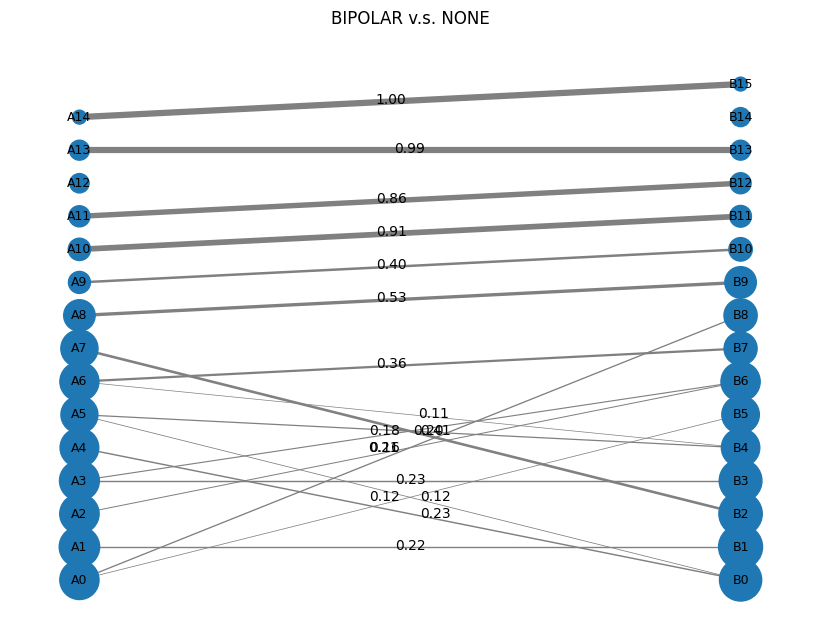

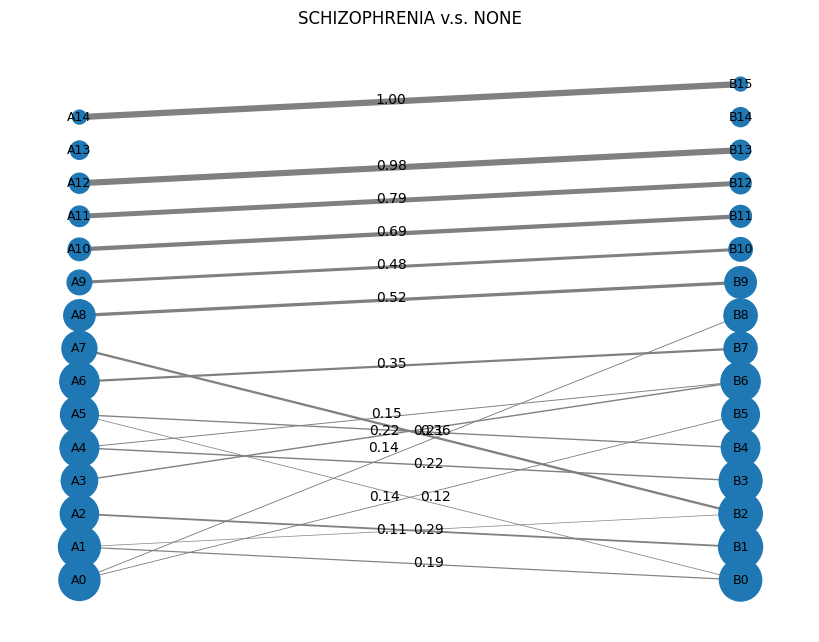

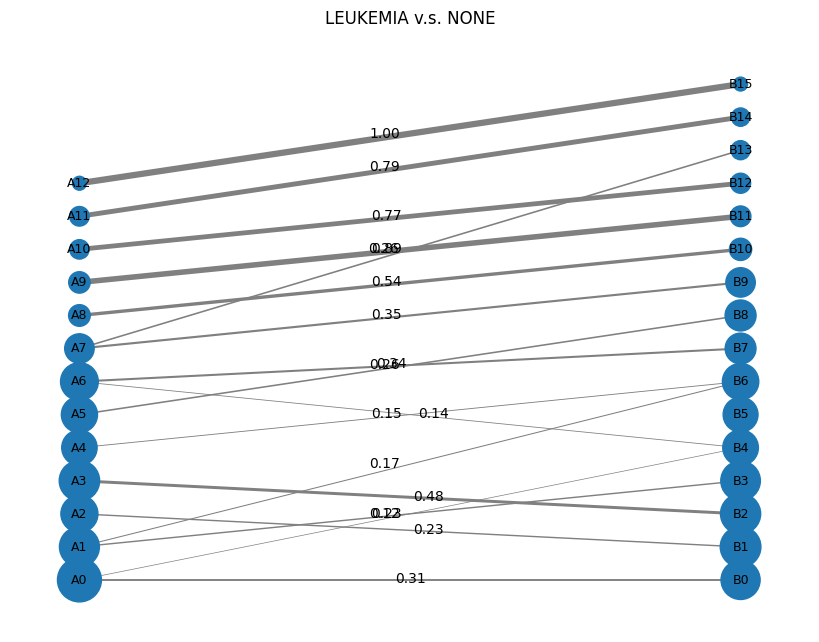

In [ ]:
disease_to_msigdb_comparison = {}
for disease in LIST_OF_DISEASES_CLEAN:
    disease_to_msigdb_comparison[disease] = draw_helper(disease,"NONE",jaccard_threshold=0.1, cap = 0, code = "selected")

C:\Users\celem\AppData\Local\Temp\ipykernel_32760\847427670.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


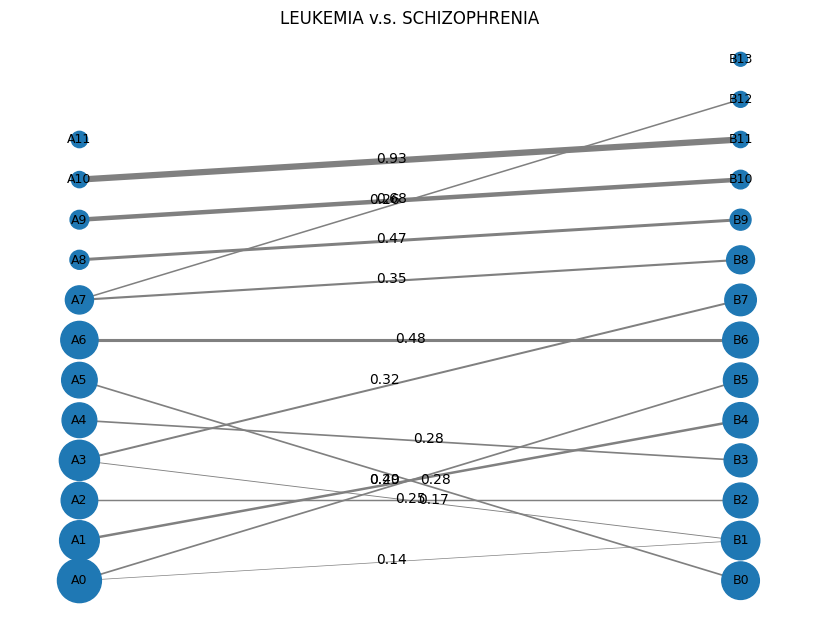

In [ ]:
draw_helper("LEUKEMIA","SCHIZOPHRENIA",jaccard_threshold=0.1, cap = 100, code = "selected")

C:\Users\celem\AppData\Local\Temp\ipykernel_32760\847427670.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


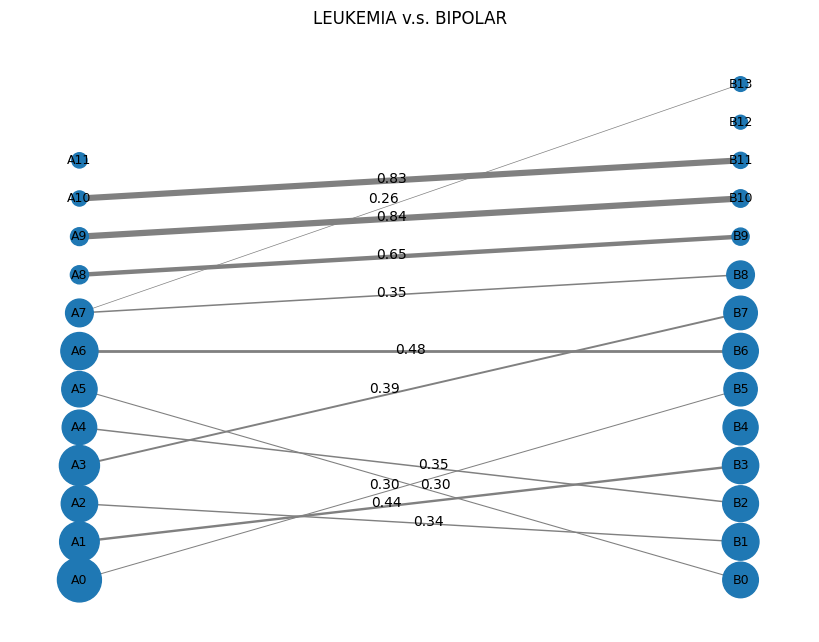

In [ ]:
draw_helper("LEUKEMIA","BIPOLAR",jaccard_threshold=0.2, cap = 100, code = "selected")

C:\Users\celem\AppData\Local\Temp\ipykernel_32760\847427670.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


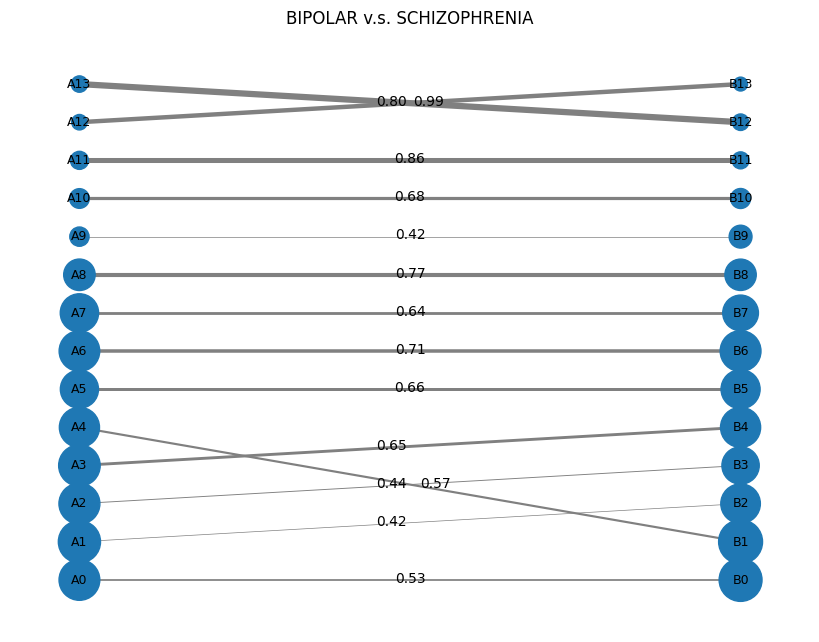

In [ ]:
draw_helper("BIPOLAR","SCHIZOPHRENIA",jaccard_threshold=0.05, cap = 100, code = "selected")

### DGIDB Genes Analysis

In [ ]:
def DGIDB_count(c,DGIDB_genes_ncbi):
    return set(c) & set(DGIDB_genes_ncbi)

In [ ]:
def print_comms_DGIDB_num(disease):
    i = 0
    for c in all_info[disease]['communities_ncbi']:
        print(f"Community {i}: {len(c)}/{len(DGIDB_count(c,all_info[disease]['DGIDB_genes']))}")
        i += 1

In [ ]:
print_comms_DGIDB_num("LEUKEMIA")

Community 0: 3517/3
Community 1: 2795/30
Community 2: 2758/0
Community 3: 2607/1
Community 4: 2548/0
Community 5: 2452/3
Community 6: 2370/5
Community 7: 1032/4
Community 8: 662/0
Community 9: 437/3
Community 10: 276/0
Community 11: 234/0
Community 12: 43/0


In [ ]:
BETWEENNESS_SCORE_CAP = 0.1

In [ ]:
for disease in LIST_OF_DISEASES:
    DGIDB_genes = all_info[disease]['DGIDB_genes']
    comms = all_info[disease]['communities']
    comms_ncbi = all_info[disease]['communities_ncbi']
    betweenness_scores = disease_to_all_betweenness_scores[disease]
    gtid = all_info[disease]['gene_to_index_distinct']
    
    print(f"\033[1m{disease}: \033[0m")
    for i,(c,s) in enumerate(zip(comms_ncbi,betweenness_scores)):
        print(f"Community {i}:")
        avg_score = sum([val for _,val in s.items()]) / len(s)
        print(f"Average score: {avg_score}")
        dgidb_genes = list(DGIDB_count(c,DGIDB_genes))
        dgidb_scores = {g:s[gtid[g]] for g in dgidb_genes}
        dgidb_scores_sorted = dict(sorted(dgidb_scores.items(), key=lambda x: x[1], reverse=True))
        print(dgidb_scores_sorted)
        print()

BIPOLAR: 
Community 0:
Average score: 0.002249161993980447
{'55534': 0.39468323759598684, '100130889': 0.24597143080884623, '652991': 0.0}

Community 1:
Average score: 0.041120733257117965
{}

Community 2:
Average score: 0.00443818633330704
{'9970': 1.0, '1002': 0.8787468553178582, '80862': 0.7227840027120096, '4049': 0.2578862383356825, '632': 0.20356798758185093, '259232': 0.06994575980873195, '12': 0.04855076988955698, '7916': 0.027187003764697487, '7504': 0.01931191678412761, '170679': 0.0005575677556336646, '236': 0.0, '26298': 0.0, '360158': 0.0}

Community 3:
Average score: 0.006295258030885658
{'7905': 1.0, '10951': 0.8661442187349572, '6728': 0.8049022816982767, '22': 0.5560103976124001}

Community 4:
Average score: 0.0011871587295527333
{'9135': 1.0, '262': 0.5769652224013992, '339896': 0.035710781334604716, '2': 0.030039119254401527, '319100': 0.015192239359841828, '267012': 0.0016678905964462943, '64816': 0.0012657760240783024, '54579': 0.0007303484983944115, '7365': 0.0}



In [ ]:
DGIDB_count(all_info['LEUKEMIA']['communities_ncbi'][1],all_info['LEUKEMIA']['DGIDB_genes'])

{'100422871',
 '100422959',
 '10866',
 '1317',
 '170679',
 '170954',
 '1831',
 '200765',
 '2114',
 '28234',
 '2952',
 '3107',
 '332',
 '3484',
 '3726',
 '4214',
 '4292',
 '4439',
 '4494',
 '462',
 '4689',
 '494514',
 '5104',
 '552859',
 '55816',
 '5858',
 '7069',
 '7916',
 '79969',
 '942'}

In [ ]:
[u for u,v in disease_to_all_betweenness_scores['LEUKEMIA'][1].items() if v >= BETWEENNESS_SCORE_CAP]

[201,
 242,
 684,
 2159,
 2934,
 2980,
 3091,
 3168,
 3463,
 4452,
 9369,
 15405,
 16968,
 17398]

### Community Detection Similarity (Term-wise)

In [ ]:
def plot_comm_jaccard_bipartite_bestboth(
    df1,
    df2,
    community_col="community_id",
    term_col="term",
    min_jaccard=0.0,
):
    # --- 1. Build sets of terms per community ---
    comm1 = (
        df1[[community_col, term_col]]
        .drop_duplicates()
        .groupby(community_col)[term_col]
        .agg(set)
    )
    comm2 = (
        df2[[community_col, term_col]]
        .drop_duplicates()
        .groupby(community_col)[term_col]
        .agg(set)
    )
    # --- 2. Best match df1 -> df2 ---
    best_12 = {}
    for cid1, set1 in comm1.items():
        best_score = 0.0
        best_cid2 = None
        for cid2, set2 in comm2.items():
            score = jaccard(set1, set2)
            if score > best_score:
                best_score = score
                best_cid2 = cid2
        if best_cid2 is not None and best_score >= min_jaccard:
            best_12[(cid1, best_cid2)] = best_score

    # --- 3. Best match df2 -> df1 ---
    best_21 = {}
    for cid2, set2 in comm2.items():
        best_score = 0.0
        best_cid1 = None
        for cid1, set1 in comm1.items():
            score = jaccard(set1, set2)
            if score > best_score:
                best_score = score
                best_cid1 = cid1
        if best_cid1 is not None and best_score >= min_jaccard:
            best_21[(best_cid1, cid2)] = best_score

    # Union of edges from both directions
    all_edges = {}
    for (c1, c2), s in {**best_12, **best_21}.items():
        all_edges[(c1, c2)] = s  # Jaccard is symmetric anyway

    # --- 4. Build graph ---
    G = nx.Graph()

    # Extract community sizes from df1 and df2
    size1 = (
        df1[[community_col, "Community Size"]]
        .drop_duplicates()
        .set_index(community_col)["Community Size"]
        .to_dict()
    )

    size2 = (
        df2[[community_col, "Community Size"]]
        .drop_duplicates()
        .set_index(community_col)["Community Size"]
        .to_dict()
    )

    # Add nodes for df1 (left)
    for cid, terms in comm1.items():
        G.add_node(f"A_{cid}", side="A", comm_id=cid, size=size1[cid])

    # Add nodes for df2 (right)
    for cid, terms in comm2.items():
        G.add_node(f"B_{cid}", side="B", comm_id=cid, size=size2[cid])

    # Add edges from union of best matches (both ways)
    for (cid1, cid2), score in all_edges.items():
        G.add_edge(f"A_{cid1}", f"B_{cid2}", weight=score)

    # --- 5. Layout: two columns ---
    left_nodes  = sorted(
        [n for n, d in G.nodes(data=True) if d["side"] == "A"],
        key=lambda n: G.nodes[n]["comm_id"],
    )
    right_nodes = sorted(
        [n for n, d in G.nodes(data=True) if d["side"] == "B"],
        key=lambda n: G.nodes[n]["comm_id"],
    )

    pos = {}
    for i, n in enumerate(left_nodes):
        pos[n] = (0.0, i)
    for i, n in enumerate(right_nodes):
        pos[n] = (1.0, i)

    # Node size ∝ community size
    def size_to_marker(s):
        return 3 * s

    node_sizes = {n: size_to_marker(G.nodes[n]["size"]) for n in G.nodes()}

    # Edge width ∝ Jaccard
    edge_weights = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
    edge_widths  = [2 + 8 * w for w in edge_weights.values()]

    # Edge labels = Jaccard
    edge_labels = {(u, v): f"{w:.2f}" for (u, v), w in edge_weights.items()}

    # Node labels = community IDs
    labels = {n: G.nodes[n]["comm_id"] for n in G.nodes()}

    # --- 6. Plot ---
    plt.figure(figsize=(10, max(4, 0.5 * max(len(left_nodes), len(right_nodes)))))

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=left_nodes,
        node_size=[node_sizes[n] for n in left_nodes],
        node_color="skyblue",
    )
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=right_nodes,
        node_size=[node_sizes[n] for n in right_nodes],
        node_color="salmon",
    )

    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    for i, (u, v) in enumerate(G.edges()):
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Midpoint of the edge
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0

        # Perpendicular unit vector to the edge
        dx = x2 - x1
        dy = y2 - y1
        length = math.hypot(dx, dy) or 1.0
        px = -dy / length
        py = dx / length

        # Spread labels along the perpendicular direction
        # pattern: -2, -1, 0, 1, 2, -2, -1, ...
        k = (i % 5) - 2
        offset = 0.06 * k   # tune this if you want more/less separation

        xl = xm + offset * px
        yl = ym + offset * py

        w = edge_weights[(u, v)]
        label = f"{w:.2f}"

        plt.text(
            xl,
            yl,
            label,
            fontsize=7,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7),
        )    
    
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return G


In [ ]:
def best_jaccard_match(
    df_source,
    df_target,
    source_community,
    *,
    community_col="community_id",
    term_col="term",
):
    """
    Compare one community in df_source to all communities in df_target.
    Returns (best_community_in_target, best_jaccard_score, all_scores_series).
    """

    # Terms for the source community
    source_terms = set(
        df_source.loc[df_source[community_col] == source_community, term_col]
    )

    if not source_terms:
        raise ValueError(f"No terms found for community {source_community!r} in df_source")

    # Build a mapping: community_id -> set of terms for df_target
    target_sets = (
        df_target[[community_col, term_col]]
        .drop_duplicates()
        .groupby(community_col)[term_col]
        .agg(set)
    )

    # Compute Jaccard score against every target community
    scores = target_sets.apply(lambda term_set: jaccard(source_terms, term_set))

    # Identify the best match
    best_community = scores.idxmax()
    best_score = scores.loc[best_community]

    return best_community, best_score, scores.sort_values(ascending=False)

def best_jaccard_analysis_left_to_right(left,right):
    for id in disease_to_df[left]["Community Index"].unique():
        best_comm, best_jaccard, all_scores = best_jaccard_match(
            df_source=disease_to_df[left],
            df_target=disease_to_df[right],
            source_community=id,
            community_col="Community Index",  # change if your column name is different
            term_col="Term",
        )
        print(f"Community {id}:")
        print("Best match in right:", best_comm)
        print("Best Jaccard score:", best_jaccard)
        print("All scores (sorted):")
        
        left_DGIDB = DGIDB_count(all_info[left]['communities_ncbi'][id],all_info[left]['DGIDB_genes'])
        right_DGIDB = DGIDB_count(all_info[right]['communities_ncbi'][best_comm],all_info[right]['DGIDB_genes'])
        print(f"Number of DGIDB terms left: {len(left_DGIDB)}")
        print(f"Number of DGIDB terms right: {len(right_DGIDB)}")
        print(f"Number of common DGIDB terms (with best match): {len(left_DGIDB & right_DGIDB)}")
        
        print(all_scores.head())
        print()

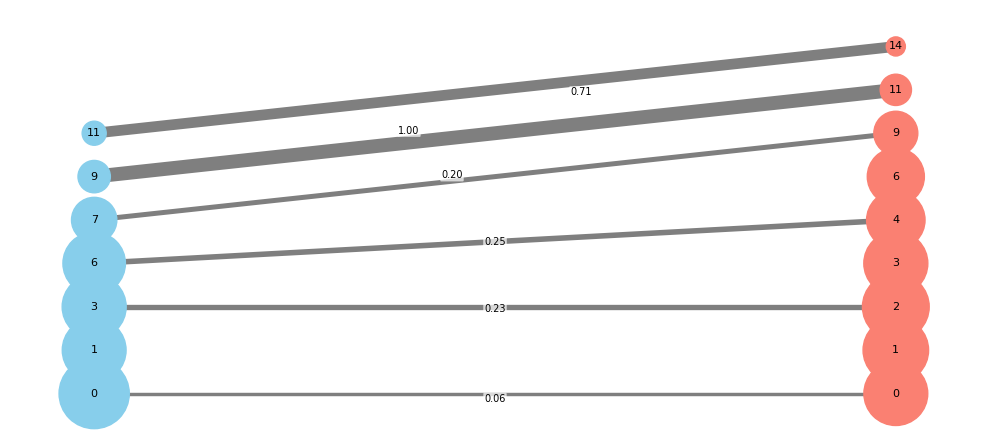

In [ ]:
plot_comm_jaccard_bipartite_bestboth(
    disease_to_df["LEUKEMIA"],
    disease_to_df["NONE"],
    community_col="Community Index",
    term_col="Term",
    min_jaccard=0.0,
)

In [ ]:
disease_to_df['NONE']

,Community Index,Community Size,Term,Overlap,Adjusted P-value,Category,Gene_set,P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,GO_ID,Slim_IDs,Overlap (value),KEGG_ID
0,0,705,Negative Regulation Of Cilium Assembly (GO:190...,7/14,7.112686e-05,['regulation of biological process'],GO_Biological_Process_2023,1.815122e-07,0.0,0.0,27.633238,428.921539,TCHP;LIMK2;TBC1D30;TESK1;CDK10;EVI5L;MAP4,GO:1902018,{'GO:0050789'},0.500000,NaN
1,0,705,Early Endosome (GO:0005769),33/307,1.031312e-06,['organelle'],GO_Cellular_Component_2023,1.381222e-08,0.0,0.0,3.409004,61.695165,WASHC4;MGRN1;TGFBRAP1;SNX13;WASHC2C;VPS26A;SNX...,GO:0005769,{'GO:0043226'},0.107492,NaN
2,0,705,Small GTPase Binding (GO:0031267),22/199,9.853579e-05,['protein binding'],GO_Molecular_Function_2023,2.239450e-06,0.0,0.0,3.479134,45.261031,DOCK5;RABGAP1L;DOCK4;ARHGEF16;RHOH;IQGAP2;CYRI...,GO:0031267,{'GO:0005515'},0.110553,NaN
3,0,705,GTPase Binding (GO:0051020),25/225,4.626256e-05,['protein binding'],GO_Molecular_Function_2023,4.205687e-07,0.0,0.0,3.510110,51.534239,DOCK5;DOCK4;YBX1;IQGAP2;RASIP1;GGA2;MICALL1;AR...,GO:0051020,{'GO:0005515'},0.111111,NaN
4,0,705,cullin-RING Ubiquitin Ligase Complex (GO:0031461),20/174,1.582728e-04,"['intracellular protein-containing complex', '...",GO_Cellular_Component_2023,3.532875e-06,0.0,0.0,3.628970,45.555901,CUL9;ZYG11B;ZER1;KLHL25;FBXO38;FBXO45;KLHL12;K...,GO:0031461,"{'GO:0140535', 'GO:1902494'}",0.114943,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,14,63,Keratinization R-HSA-6805567,58/208,1.043546e-111,['Developmental Biology'],Reactome_2022,1.043546e-112,0.0,0.0,1530.194667,394555.960866,KRTAP24-1;KRTAP26-1;KRT24;LCE1A;CASP14;KRT26;K...,NaN,NaN,0.278846,NaN
883,14,63,Intermediate Filament Organization (GO:0045109),14/68,3.259996e-21,['cellular component organization or biogenesi...,GO_Biological_Process_2023,2.173331e-22,0.0,0.0,105.201058,5247.493079,KRT82;KRT24;KRT79;KRT35;KRT78;KRT77;KRT73;KRT8...,GO:0045109,"{'GO:0071840', 'GO:0045103'}",0.205882,NaN
884,14,63,Keratin Filament (GO:0045095),7/39,2.790053e-10,['supramolecular complex'],GO_Cellular_Component_2023,3.100059e-11,0.0,0.0,77.753906,1881.412426,KRT82;KRT79;KRT78;KRT77;KRT84;KRT73;KRT72,GO:0045095,{'GO:0099080'},0.179487,NaN
885,14,63,Intermediate Filament (GO:0005882),7/69,9.091580e-09,['supramolecular complex'],GO_Cellular_Component_2023,2.020351e-09,0.0,0.0,40.070565,802.212481,KRT82;KRT79;KRT78;KRT77;KRT73;KRT84;KRT72,GO:0005882,{'GO:0099080'},0.101449,NaN


In [ ]:
best_jaccard_analysis_left_to_right("BIPOLAR","NONE")

Community 0:
Best match in right: 0
Best Jaccard score: 0.06451612903225806
All scores (sorted):
Number of DGIDB terms left: 3
Number of DGIDB terms right: 126
Number of common DGIDB terms (with best match): 0
Community Index
0    0.064516
2    0.003708
1    0.000000
3    0.000000
4    0.000000
Name: Term, dtype: float64

Community 1:
Best match in right: 14
Best Jaccard score: 0.4
All scores (sorted):
Number of DGIDB terms left: 0
Number of DGIDB terms right: 0
Number of common DGIDB terms (with best match): 0
Community Index
14    0.4
0     0.0
1     0.0
2     0.0
3     0.0
Name: Term, dtype: float64

Community 3:
Best match in right: 6
Best Jaccard score: 0.075
All scores (sorted):
Number of DGIDB terms left: 4
Number of DGIDB terms right: 16
Number of common DGIDB terms (with best match): 3
Community Index
6    0.075
0    0.000
1    0.000
2    0.000
3    0.000
Name: Term, dtype: float64

Community 4:
Best match in right: 0
Best Jaccard score: 0.07194244604316546
All scores (sorted)

### L10, S11, B11, N12 Analysis

In [ ]:
L10 = all_info['LEUKEMIA']['communities_selected_ncbi'][10]
S11 = all_info['SCHIZOPHRENIA']['communities_selected_ncbi'][11]
B11 = all_info['BIPOLAR']['communities_selected_ncbi'][11]
N12 = all_info['NONE']['communities_selected_ncbi'][12]

In [ ]:
print(jaccard(L10,S11))
print(jaccard(L10,B11))
print(jaccard(S11,B11))
print(jaccard(S11,N12))

0.9329268292682927
0.8260869565217391
0.861878453038674
0.7914438502673797


### TBD

In [ ]:
disease_to_df['BIPOLAR']["Community Index"].value_counts()

Community Index
7     885
4     119
3      78
8      43
5      19
12     17
6      14
10      9
0       3
1       2
Name: count, dtype: int64

In [ ]:
disease_to_df['SCHIZOPHRENIA']["Community Index"].value_counts()

Community Index
7     416
1     131
6      22
8      20
4      16
10      9
5       8
13      6
Name: count, dtype: int64

In [ ]:
disease_to_df['LEUKEMIA']["Community Index"].value_counts()

Community Index
3     394
0      95
1      27
7      27
9       9
11      7
6       3
Name: count, dtype: int64

In [ ]:
disease_to_df['LEUKEMIA']

,Community Index,Community Size,Term,Overlap,Adjusted P-value,Category,Gene_set,P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,GO_ID,Slim_IDs,Overlap (value),KEGG_ID
0,0,852,THO Complex Part Of Transcription Export Compl...,4/5,1.830181e-04,['nuclear protein-containing complex'],GO_Cellular_Component_2023,1.580013e-05,0.0,0.0,90.316038,998.488291,THOC2;THOC5;THOC7;THOC6,GO:0000445,{'GO:0140513'},0.800000,NaN
1,0,852,Organelle Assembly (GO:0070925),34/322,1.218204e-04,['cellular component organization or biogenesis'],GO_Biological_Process_2023,1.125962e-06,0.0,0.0,2.721917,37.281746,STX12;GALNT11;MACIR;C2CD3;WDR45B;FXR1;RAB43;AP...,GO:0070925,{'GO:0071840'},0.105590,NaN
2,0,852,GTPase Activity (GO:0003924),28/265,8.870775e-04,['hydrolase activity'],GO_Molecular_Function_2023,9.659647e-06,0.0,0.0,2.711421,31.310280,SAR1A;RGS14;GSPT1;RAB22A;RAB43;RAB21;RGS2;RAB2...,GO:0003924,{'GO:0016787'},0.105660,NaN
3,0,852,mRNA Binding (GO:0003729),30/282,4.508159e-04,['nucleic acid binding'],GO_Molecular_Function_2023,4.090888e-06,0.0,0.0,2.736647,33.952890,FYTTD1;YTHDC1;POLDIP3;CELF2;SRSF1;CELF4;PARN;N...,GO:0003729,{'GO:0003676'},0.106383,NaN
4,0,852,Organelle Organization (GO:0006996),48/418,1.251937e-07,['cellular component organization or biogenesis'],GO_Biological_Process_2023,4.450542e-10,0.0,0.0,3.029931,65.242983,DYRK3;SAR1A;PITPNB;PEX11B;FAF2;TOR1AIP2;FITM2;...,GO:0006996,{'GO:0071840'},0.114833,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,11,100,Cornified Envelope (GO:0001533),5/41,9.176351e-06,['membrane'],GO_Cellular_Component_2023,1.835270e-06,0.0,0.0,29.040936,383.581937,SPRR2G;TCHH;DSG4;SPRR2B;SPRR2D,GO:0001533,{'GO:0016020'},0.121951,NaN
558,11,100,Keratin Filament (GO:0045095),12/39,6.471343e-18,['supramolecular complex'],GO_Cellular_Component_2023,4.314228e-19,0.0,0.0,100.368687,4244.310563,KRT82;KRT36;KRT79;KRT78;KRT77;KRT76;KRT86;KRT7...,GO:0045095,{'GO:0099080'},0.307692,NaN
559,11,100,Intermediate Filament Organization (GO:0045109),21/68,3.071962e-31,"['intermediate filament-based process', 'cellu...",GO_Biological_Process_2023,7.876825e-33,0.0,0.0,112.284675,8300.238517,KRT82;KRT24;TCHH;KRT35;KRT79;KRT78;KRT77;KRT76...,GO:0045109,"{'GO:0045103', 'GO:0071840'}",0.308824,NaN
560,11,100,Epidermis Development (GO:0008544),9/85,5.290325e-09,['anatomical structure development'],GO_Biological_Process_2023,4.069481e-10,0.0,0.0,25.797571,557.803731,KRTDAP;CASP14;KRTAP5-9;SPRR2G;KLK14;KRT31;KRT8...,GO:0008544,{'GO:0048856'},0.105882,NaN


### Preliminary Gene Comparison (to introduce a new disease)

In [ ]:
NEW_DISEASE = "PARKINSON"

In [ ]:
NEW_DGIDB_DIRECTORY = DGIDB_DIRECTORY = f"../../Gen_Hypergraph/output/DGIDB_{NEW_DISEASE}/"

In [ ]:
with open(NEW_DGIDB_DIRECTORY + f"gene_to_index_{NEW_DISEASE}.json", "r") as file:
    new_DGIDB_gene_to_index = json.load(file)
with open(NEW_DGIDB_DIRECTORY + f"drug_to_index_{NEW_DISEASE}.json", "r") as file:
    new_DGIDB_drug_to_index = json.load(file)

In [ ]:
new_genes = set(new_DGIDB_gene_to_index.keys())
new_drugs = set(new_DGIDB_drug_to_index.keys())

In [ ]:
print(new_genes)

{'1815', '5565', '7442', '9682', '1562', '1993', '135', '54737', '9135', '100302251', '1742', '26', '2904', '22', '4524', '10951', '3558', '1559', '2', '3952', '3028', '100302144', '5965', '1271', '2952', '50852', '3350', '3164', '218', '581', '1', '3269', '2944', '11201', '59340', '6531', '5429', '328', '24', '4129', '7365', '2194', '4363', '4137', '1544', '5020', '4160', '100', '2675', '2237', '25970', '6505', '28755', '23', '51426', '2289', '2641', '2166', '627', '1543', '641', '12', '54658', '217', '4915', '718', '215', '3358', '2740', '4907', '6532', '3727', '1557', '216', '390245', '84062', '1644', '4835', '1816', '6714', '265', '3359', '262', '13', '1812', '3127', '1576', '3760', '3115', '4781', '3248', '5563', '3363', '3356', '887', '5594', '3176', '203', '5617', '1813', '3', '11', '10919', '6580', '9429', '10', '1621', '3125', '185', '64816', '1565', '1128', '54657', '1814', '7957', '3600', '23216', '3106', '2668', '3699', '214', '7486', '3107', '5294'}


In [ ]:
len(new_genes & all_info["BIPOLAR"]['DGIDB_genes']) 

99

In [ ]:
CLOZA_genes = [     1813,      6714,     64816,      9429,      1543,        12,
            3107,       262,      2952,      3356,     25970,       718,
            7365,      4363,      3127,      2904,      1562,     54658,
               1,         3,        11,      2740,      2675,      2668,
            4524,      1557,      4907,      3350,      4781,      3125,
              24,       215,       217,      3359,      2944,      1565,
             265, 100302144,      2166,      1576,      1812,      3363,
       100302251,        26,      1128,     28755,        22,       218,
            5294,      3358,     11201,      2194,      3558,      1993,
             887,      5565,      3115,      4160,        23,      6505,
            3952,      3699,     23216,      5617,      2641,     84062,
            3106,     50852,      9135,      7957,      2289,      6532,
              10,       216,      6531,      1544,      5020,        13,
           10951,      3727,      3760,      1559,     54657,      5563,
            4915,      3176,      4835,         2,       214,     59340,
            1815,      3269]

In [ ]:
CLOZA_genes = set([str(i) for i in CLOZA_genes])

In [ ]:
print(CLOZA_genes)

{'1815', '5565', '1562', '1993', '9135', '100302251', '26', '2904', '22', '4524', '10951', '3558', '1559', '2', '3952', '100302144', '2952', '50852', '3350', '218', '3269', '1', '2944', '11201', '59340', '6531', '24', '7365', '2194', '4363', '1544', '5020', '4160', '2675', '25970', '6505', '28755', '23', '2289', '2641', '2166', '1543', '12', '54658', '217', '4915', '718', '215', '3358', '2740', '4907', '6532', '3727', '1557', '216', '84062', '4835', '6714', '265', '3359', '262', '13', '1812', '3127', '1576', '3760', '3115', '4781', '5563', '3363', '3356', '887', '3176', '5617', '1813', '3', '11', '9429', '10', '3125', '64816', '1565', '1128', '54657', '7957', '3106', '23216', '2668', '3699', '214', '3107', '5294'}


In [ ]:
# Common genes in communities 8 (both diseases) that are also in CLOZA_genes
print(len(CLOZA_genes & DGIDB_count(all_info['BIPOLAR']['communities_ncbi'][8],all_info['BIPOLAR']['DGIDB_genes']) & DGIDB_count(all_info['SCHIZOPHRENIA']['communities_ncbi'][8],all_info['SCHIZOPHRENIA']['DGIDB_genes'])))

22


# Community Description

In [60]:
def create_communities_attributes_df(disease):
    comms = all_info[disease]['communities']
    msigdb_comp_graph = disease_to_msigdb_comparison[disease]
    edge_list = [(u, v, data["weight"]) for u, v, data in msigdb_comp_graph.edges(data=True)]
    comms_ncbi = all_info[disease]['communities_ncbi']
    DGIDB_genes = all_info[disease]['DGIDB_genes']
    betweenness_scores = disease_to_all_betweenness_scores[disease]
    gtid = all_info[disease]['gene_to_index_distinct']
    
    # compute msigdb connection weight for each community
    comm_to_total_weights = {}
    
    for i in range(len(comms)):
        comm_to_total_weights[i] = 0
    for edge in edge_list:
        weight = edge[2]
        comm_id = int(edge[0].split("_")[1])
        comm_to_total_weights[comm_id] += weight
    
    # compute number of DGIDB genes

    total_num_dgidb_genes = 0
    comm_to_num_dgidb_genes = {}
    
    for i,c in enumerate(comms_ncbi):
        num_dgidb_genes = len(DGIDB_count(c,DGIDB_genes))
        total_num_dgidb_genes += num_dgidb_genes
        comm_to_num_dgidb_genes[i] = num_dgidb_genes
    
    
    # betweenness score for DGIDB genes

    comm_to_betweenness_score = {}
    comm_to_average_score = {}
    
    for i,(c,s) in enumerate(zip(comms_ncbi,betweenness_scores)):
        avg_score = sum([val for _,val in s.items()]) / len(s)
        comm_to_average_score[i] = avg_score
        dgidb_genes = list(DGIDB_count(c,DGIDB_genes))
        dgidb_scores = {g:s[gtid[g]] for g in dgidb_genes}
        dgidb_scores_sorted = dict(sorted(dgidb_scores.items(), key=lambda x: x[1], reverse=True))
        comm_to_betweenness_score[i] = dgidb_scores_sorted
    
    # # print result
    # print(f"Disease: {disease}")
    # print(f"Number of communities: {len(comms)}\n")
    # for i,c in enumerate(comms):
    #     print(f"\033[1mCommunity {i}:\033[0m")
    #     print(f"Total connection weight to MsigDB: {comm_to_total_weights[i]}")
    #     print(f"Number of DGIDB genes: {comm_to_num_dgidb_genes[i]}")
    #     print(f"Average betweenness score: {comm_to_average_score[i]}")
    #     print(f"DGIDB genes betweenness score: {comm_to_betweenness_score[i]}")
    #     print(f"Total number of DGIDB genes (in communities greater than size_cap): {total_num_dgidb_genes}")
    #     print()
        
    # create dataframe
    community_attributes = pd.DataFrame({
        "msigdb_connection_weight": comm_to_total_weights,
        "num_dgidb_genes": comm_to_num_dgidb_genes,
        "avg_btn_score": comm_to_average_score,
        "dgidb_genes_btn_score": comm_to_betweenness_score,
    })
    
    return community_attributes
    

In [61]:
p = create_communities_attributes_df('SCHIZOPHRENIA')

In [62]:
p[p['msigdb_connection_weight'] > 0.60]

,msigdb_connection_weight,num_dgidb_genes,avg_btn_score,dgidb_genes_btn_score
10,0.690083,4,0.009260,"{'3363': 1.0, '59340': 0.46929968765411806, '2..."
11,0.791444,0,0.019184,{}
12,0.980132,1,0.007175,{'926': 1.0}
14,1.000000,0,0.030439,{}


# Filtering

In [63]:
# components = list(nx.connected_components(G))
# for i, comp in enumerate(components):
#     print(f"Component {i} ({len(comp)} nodes):")
#     print(comp)